# Introduction

This code makes diagnostic figures for various fields of interest to the NEMO-AGCM coupling process. Choose filepaths of the run of interest under the *Input files* section below. 

### Details and todo

For the most part fields stored in the coupler history file are used to compare fields on the AGCM/NEMO grid. It might be worthwile to check these against fields stored in the ice/grid_t/AGCM history files. We may also want to branch out to more specific AGCM/OGCM diagnostics using those history files. Some other things todo:

  - automatic color range scaling, as in validate
  
  - abstract plotting to a function
  
  - file retrieval?
  
  - homogenize naming convention for output PDFs
  
  - Comparison of coupler and NEMO history files for overlapping variables.
  
  - Add AGCM fields?
  
### Weird things to be aware of and double check in coupling  

  - AGCM and LIM compute ice temperature independently. There is no constraint that they be similar (but they are connected by the fluxes).
  
  - Wind stresses are not tiled - meaning land induced stresses are being felt over the ocean.
  
  - Runoff is currently not being sent into the ocean.
  
  - Sea-ice tiled fields coming from the AGCM have values over non sea-ice areas.
  
  - Many variables are saved in the coupler history file and in area-specific history files. The hope is that these are consistent (e.g. OIceFra and soicecov in the cpl_hist and icemod files).
  
  - Non-solar heat flux is computed as the difference between the total flux and the solar flux.
  
  - Sublimation is not sent directly from the atmosphere. The heat flux is sent, and division by the latent heat of sublimation gives the water flux. This could be problematic if this value is ever changed. Would be more satisfying to send the submlimation in kg/m2/s.

## Notebook and python configuration

All required libraries are imported here and all notebook settings are specified.  

In [95]:
%matplotlib inline  
import matplotlib.pyplot as plt
import numpy as np
import cmipdata as cd
import netCDF4 as nc4

Below useful functions are defined, which are used repeatedly.

In [96]:
def add_cbar(cot, ax, units, **kwargs):
    """Adds a cbar to a plot in its own axis"""
    box = ax.get_position()
    fig = ax.get_figure()
    tl = fig.add_axes([box.x0+box.width*1.035, box.y0, 0.02, box.height])
    #bounds = np.linspace(vmin, vmax, ncols)
    fig.colorbar(cot, cax=tl, label=units, **kwargs)

def axtight(axa):    
    """Makes axis tight for a sequences of axes"""
    for ax in axa:
        ax.autoscale(enable=True, axis='both', tight=True)
        
def plt_agcm_nemo(data, titles, units, figname, cmap=None, anom=False, minmax=None, save=True, **kwargs):
    """ Side-by-side plots of data on AGCM and NEMO grids.
    
    Parameters:
    -----------
      data : list
        Two 2D arrays for mapping (AGCM/NEMO data arrays)
      titles : list
        Contains two strings used to label the plots
      units : string
        units for labelling the colorbar
      figname : string
        name used to save the PDF output, should end in ".pdf"
      cmap: mpl colormap or string  
        colormap to use, defaults to 'YlOrRd' if anom=False, or 'coolwarm' if anom=True.
      anom : boolean
        If true center the minmax around zero (if minmax not specified)
      minmax : tuple
        min and max values of the colorbar. Otherwise autoset to min/max of 
        data (default).
      save : boolean
        Saves figure as figname if True (default)
    
      Returns:
      --------
        fig : matplotlib figure
        axa  : array of matplotlib axes 
    """
    fig, axa = plt.subplots(1,2, figsize=(8,8))
    plt.subplots_adjust(wspace=0.15, top=0.5)

    if not cmap:
        cmap = 'YlOrRd'
        if anom:
            cmap ='coolwarm'
            
    if not minmax:
        mmin = np.ma.min([data[0].min(), data[1].min()])
        mmax = np.ma.max([data[0].max(), data[1].max()])
        if anom:
            mm = np.ma.max([abs(mmin), mmax])
            minmax = (-1*mm, mm)
        else:
            minmax = (mmin, mmax)
            
    cot = axa[0].pcolormesh(data[0], cmap=cmap, vmin=minmax[0], vmax=minmax[1], rasterized=True)
    cot = axa[1].pcolormesh(data[1], cmap=cmap, vmin=minmax[0], vmax=minmax[1], rasterized=True)
    add_cbar(cot, axa[1], units)
    axa[0].set_title(titles[0])
    axa[1].set_title(titles[1])
    axtight(axa)
    
    if save:
        fig.savefig(figname, bbox_inches='tight')
    
    return fig, axa

## Input files and variable loading

Data from the files specified here is used in all the plots below. No new files are specified beyond here.

In [97]:
# ================= COUPLER HISTORY FILE (cplhist.nc) =================
run='lim41' # For convenience. Just specify the full path to a file in these variables to make sure this works.
year = '2342'
ifile_cplhist = '/raid/ra40/data/ncs/nemo_out/coupled/{run}/mc_tcpl_{run}_{year}_m01_cplhist.nc.001'.format(run=run, year=year)
#ifile_cplhist = 'data/mc_tcpl_lim20_2338_m01_cplhist.nc.001'

# ================= SEA-ICE HISTORY FILE (icemod.nc) =================
#ifile_icemod = '/raid/ra40/data/ncs/nemo_out/coupled/{run}/mc_tcpl_{run}_3h_{year}0101_{year}0131_icemod.nc.001'.format(run=run, year=year)
ifile_icemod_1m = '/raid/ra40/data/ncs/nemo_out/coupled/{run}/mc_tcpl_{run}_1m_{year}0101_{year}0131_icemod.nc.001'.format(run=run, year=year)

#ifile_icemod = 'data/mc_tcpl_lim20_3h_23380101_23380131_icemod.nc.001'

# ================= GRID_T HISTORY FILE (grid_t.nc) =================
ifile_grid_t = '/raid/ra40/data/ncs/nemo_out/coupled/{run}/mc_tcpl_{run}_1m_{year}0101_{year}0131_grid_t.nc.001'.format(run=run, year=year)
#ifile_grid_t = 'data/mc_tcpl_lim20_1m_23380101_23380131_grid_t.nc.001'

# ================= MESH FILE (mesh_mask.nc) =================
# This does not need to change. Should be the same of all ORCA1 runs, unless land definition has changed.
#mfile = '/raid/ra40/data/ncs/nemo_out/nemo_3.4_orca1_mesh_mask.nc'
mfile = 'data/nemo_3.4_orca1_mesh_mask.nc'

# ================= SAVING OPTIONS =================
# Save individual PDFs for each figure?
save_pdf = False
# Save a merged PDF of this notebook without code?
save_nb = True
# Figures are saved by this script, and their names are prepended with the prefix specified here:
outpref = '{run}-{year}_'.format(run=run, year=year)


In [98]:
print "# Plots are for run: ", run
ifile_cplhist

# Plots are for run:  lim41


'/raid/ra40/data/ncs/nemo_out/coupled/lim41/mc_tcpl_lim41_2342_m01_cplhist.nc.001'

Ignore this unless you want to add a new variable. Here ALL required variables are loaded. By default a mean over all times is taken, and values identically equal to zero (default missing value) are masked.

In [99]:
# ================= FROM COUPLER HISTORY FILE (cplhist.nc) =================
lon_a = cd.loadvar(ifile_cplhist, 'lon_a')
lat_a = cd.loadvar(ifile_cplhist, 'lat_a')

FSGO_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'FSGO_atm').mean(axis=0), 0)
BEGO_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'BEGO_atm').mean(axis=0), 0)
O_QsrOce = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_QsrOce').mean(axis=0), 0)
O_QnsOce = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_QnsOce').mean(axis=0), 0)

FSGI_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'FSGI_atm').mean(axis=0), 0)
BEGI_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'BEGI_atm').mean(axis=0), 0)
O_QsrIce = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_QsrIce').mean(axis=0), 0)
O_QnsIce = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_QnsIce').mean(axis=0), 0)

dqns_agcm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'SLIM_atm').mean(axis=0), 0)
dqns_lw_agcm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'SLIMlw_atm').mean(axis=0), 0)
dqns_sh_agcm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'SLIMsh_atm').mean(axis=0), 0)
dqns_lh_agcm = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'SLIMlh_atm').mean(axis=0), 0)
mask_ocn= cd.loadvar(ifile_cplhist,'mask_ocn')
o_dqnsdt = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_dQnsdT').mean(axis=0), 0)

sicn_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'SICN_atm').mean(axis=0), 0)
sic_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'SIC_atm').mean(axis=0), 0)
sno_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'SNO_atm').mean(axis=0), 0)

oicefrc = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OIceFrc').mean(axis=0), 0)
oisubmsn = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OISubMSn').mean(axis=0), 0)
oicetck = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OIceTck').mean(axis=0), 0)
osnwtck = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OSnwTck').mean(axis=0), 0)

rain_atm = cd.loadvar(ifile_cplhist,'RAIN_atm').mean(axis=0)
snow_atm = cd.loadvar(ifile_cplhist,'SNOW_atm').mean(axis=0)
hfli_atm = cd.loadvar(ifile_cplhist,'HFLI_atm').mean(axis=0)
rofo_atm = cd.loadvar(ifile_cplhist,'ROFO_atm').mean(axis=0)
bwgo_atm = cd.loadvar(ifile_cplhist,'BWGO_atm').mean(axis=0)
gtice_atm = cd.loadvar(ifile_cplhist,'GTICE_atm').mean(axis=0)                                  # * MIN *

oiceevap = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OIceEvap').mean(axis=0), 0)
o_runoff = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_Runoff').mean(axis=0), 0)
ooevapmpr = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OOEvaMPr').mean(axis=0), 0)

gtice_ocn = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'GTICE_ocn').mean(axis=0),0)            # * MIN *
gt_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'GT_atm').mean(axis=0),0)

o_tepice = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_TepIce').mean(axis=0),0)              # * MIN *
o_sstsst = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_SSTSST').mean(axis=0),0)             # * MIN *

ufso_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'UFSO_atm').mean(axis=0),0)       
vfso_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'VFSO_atm').mean(axis=0),0)       
ufsi_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'UFSI_atm').mean(axis=0),0)       
vfsi_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'VFSI_atm').mean(axis=0),0)       
swmx_atm = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'SWMX_atm').mean(axis=0),0)       

o_otaux1 = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_OTaux1').mean(axis=0),0)       
o_otauy1 = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_OTauy1').mean(axis=0),0)       
o_itaux1 = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_ITaux1').mean(axis=0),0)       
o_itauy1 = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_ITauy1').mean(axis=0),0)       
o_wind10 = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_Wind10').mean(axis=0),0)       


# ================= SEA-ICE HISTORY FILE (icemod.nc) =================
if '1m' in ifile_icemod:
    iicetemp = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'iicetemp'),0)#.mean(axis=0)             # * MIN *
    soicecov = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'soicecov'),0)#.mean(axis=0)
    iicethic = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'iicethic'),0)#.mean(axis=0)
    isnowthi = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'isnowthi'),0)#.mean(axis=0)
else:
    iicetemp = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'iicetemp'),0).mean(axis=0)             # * MIN *
    soicecov = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'soicecov'),0).mean(axis=0)
    iicethic = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'iicethic'),0).mean(axis=0)
    isnowthi = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'isnowthi'),0).mean(axis=0)
    
# Define an ice mask where sicn > 0. 
imask = soicecov.copy()
imask[imask>0] = 1.0

# ================= GRID_T HISTORY FILE (grid_t.nc) =================
nc = nc4.Dataset(ifile_grid_t, 'r')
sst = np.ma.masked_equal(nc.variables['votemper'][:,0,:,:].mean(axis=0), 0)
sss = np.ma.masked_equal(nc.variables['vosaline'][:,0,:,:].mean(axis=0), 0)
#thetao = np.ma.masked_equal(cd.loadvar(ifile_grid_t, 'votemper').mean(axis=0), 0)
#so = np.ma.masked_equal(cd.loadvar(ifile_grid_t, 'vosaline').mean(axis=0), 0)

# ================= MESH FILE (mesh_mask.nc) =================
tmask = cd.loadvar(mfile, 'tmask')[0,:,:].squeeze()
e1t = cd.loadvar(mfile, 'e1t')
e2t = cd.loadvar(mfile, 'e2t')


RuntimeError: No such file or directory

## Fixed fields

NEMO-defined binary land mask

In [ ]:
fig, axa = plt.subplots(1,1, figsize=(8,8))

cot = axa.pcolormesh(mask_ocn, cmap='Set3', vmin=0, vmax=1, rasterized=True)
#add_cbar(cot, axa, '', boundaries=[0, 1])
axa.set_title('NEMO binary land mask')
axtight([axa])
if save_pdf:
    fig.savefig(outpref + 'land_mask.pdf', bbox_inches='tight')

## AGCM derived fluxes

### AGCM to Ocean 

#### Heat fluxes 

Solar fluxes on the AGCM and NEMO grids:

In [ ]:
fig, axa = plt_agcm_nemo([FSGO_atm, O_QsrOce], ['FSGO_atm', 'O_QsrOce'], units='W m$^2$', 
              figname=outpref + 'agcm-flx_solar.pdf', save=save_pdf)

Non-solar fluxes on the AGCM and NEMO grids

In [ ]:
fig, axa = plt_agcm_nemo([BEGO_atm-FSGO_atm, O_QnsOce], ['BEGO_atm - FSGO_atm', 'O_QnsOce'], units='W m$^2$', 
              figname=outpref + 'agcm-flx_non_solar.pdf', cmap='Blues_r', save=save_pdf)

Total heat flux to ocean on AGCM grid (BEGO_atm). Not used by NEMO.

In [ ]:
fig, axa = plt.subplots(1,1, figsize=(8,8))
cot = axa.pcolormesh(BEGO_atm, vmin=-850, vmax=850, cmap='coolwarm', rasterized=True)
add_cbar(cot, axa, 'W m$^2$')
axa.set_title('BEGO_atm')
axtight([axa])
if save_pdf:
    fig.savefig(outpref + 'agcm-flx_BEGO_atm.pdf', bbox_inches='tight')

#### Water fluxes

Below are rain and snow on the AGCM grid. Rain and snow are not used directly by the ocean (see E-P terms that follow for ocean and sea-ice).

In [ ]:
fig, axa = plt.subplots(2,1, figsize=(8,8))
plt.subplots_adjust(right=0.5)

sec2day = 3600.*24.
varl = [rain_atm, snow_atm]

tits = ['Rain', 'Snow']

for i, ax in enumerate(axa.flatten()):
    #vp = np.ma.masked_equal(varl[i]*tmask*imask, 0)
    cot = ax.pcolormesh(varl[i]*sec2day, cmap='Blues', vmin=0, vmax=10, rasterized=True)
    ax.text(10,60, str(np.round(varl[i].mean()*sec2day,2)))
    ax.set_title(tits[i])
    #print tits[i], varl[i].mean()

add_cbar(cot, axa[1], units=r'mm day$^{-1}$')
axtight(axa.flatten())
if save_pdf:
    fig.savefig(outpref + 'agcm-flx_rain_snow.pdf', bbox_inches='tight')

River runoff:

In [ ]:
fig, axa = plt_agcm_nemo([rofo_atm*sec2day, o_runoff*sec2day], ['ROFO_atm', 'O_Runoff'], units=r'mm day$^{-1}$', 
              figname=outpref + 'agcm-flx_runoff.pdf', cmap='Blues', save=save_pdf)

Evaporation minus precipitation over the open ocean

In [ ]:
fig, axa = plt_agcm_nemo([bwgo_atm*sec2day, ooevapmpr*sec2day], [r'$-1 \times$ BWGO_atm', 'OOEvaMPr'], 
                         units=r'mm day$^{-1}$', figname=outpref + 'agcm-EmP.pdf', anom=True, 
                         save=save_pdf)

#### Momentum flux and wind

Zonal wind stresses on the AGCM and NEMO grids. ATM fields are revered in sign. Note land values are included (i.e. stresses are not yet tiled). Hence, high values around some land points.

In [ ]:
fig, axa = plt_agcm_nemo([ufso_atm*-10, o_otaux1*10], [r'$-1 \times$ UFSO_atm', 'O_Otaux1'], 
                         units=r'$\times 10^{-1}$ Pa', figname=outpref + 'agcm-taux.pdf', anom=True, save=save_pdf)

Meridional wind stresses on the AGCM and NEMO grids.

In [ ]:
fig, axa = plt_agcm_nemo([vfso_atm*-10, o_otauy1*10], [r'$-1 \times$ VFSO_atm', 'O_Otauy1'], 
                         units=r'$\times 10^{-1}$ Pa', figname=outpref + 'agcm-tauy.pdf', anom=True, save=save_pdf)

Wind speed

In [ ]:
fig, axa = plt_agcm_nemo([swmx_atm, o_wind10], ['SWMX_atm', 'O_Wind10'], 
                         units=r'm s$^{-1}$', figname=outpref + 'agcm-wspd.pdf', anom=False, save=save_pdf)

### AGCM to Sea-ice

#### Heat fluxes

Solar flux over sea-ice on the AGCM and NEMO grids:

In [ ]:
fig, axa = plt_agcm_nemo([FSGI_atm, O_QsrIce], ['FSGI_atm', 'O_QsrIce'], 
                         units=r'W m$^{-2}$', figname=outpref + 'flx_sea-ice_solar.pdf', anom=False, save=save_pdf)

Non-solar flux over sea-ice on the AGCM and NEMO grids:

In [ ]:
fig, axa = plt_agcm_nemo([BEGI_atm - FSGI_atm, O_QnsIce], ['BEGI_atm - FSGI_atm', 'O_QnsIce'], 
                         units=r'W m$^{-2}$', figname=outpref + 'flx_sea-ice_non-solar.pdf', anom=True, 
                         save=save_pdf)

BEGI_atm is the total heat flux over ice, not directly used in NEMO

In [ ]:
fig, axa = plt.subplots(1,1, figsize=(8,8))
cot = axa.pcolormesh(BEGI_atm, vmin=-850, vmax=850, cmap='coolwarm', rasterized=True)
add_cbar(cot, axa, 'W m$^2$')
axa.set_title('BEGI_atm')
axtight([axa])
if save_pdf:
    fig.savefig(outpref + 'sea-ice-flx_BEGI_atm.pdf', bbox_inches='tight')

Dqnsdt terms from the atmosphere:

In [ ]:
fig, axa = plt.subplots(2,2, figsize=(8,8))
plt.subplots_adjust(wspace=0.35)

varl = [dqns_agcm, dqns_lw_agcm, dqns_sh_agcm, dqns_lh_agcm]

tits = ['Dqns/Dt', 'Dqlw/DT', 'Dqsb/DT', 'Dqla/DT']

for i, ax in enumerate(axa.flatten()):
    #vp = np.ma.masked_equal(varl[i]*tmask*imask, 0)
    cot = ax.pcolormesh(varl[i], cmap='Blues_r', vmin=-45, vmax=0, rasterized=True)
    ax.text(60,30, str(np.round(varl[i].mean(),2)))
    ax.set_title(tits[i])
    #print tits[i], varl[i].mean()

add_cbar(cot, axa[0,1], units='W m$^{-2}$ K$^{-1}$')
axtight(axa.flatten())
if save_pdf:
    fig.savefig(outpref + 'agcm-flx_DqnsDt_AGCM.pdf', bbox_inches='tight')

Dqnsdt terms going to the ocean. Note these may differ due to the bulk formula dqnsdt being used in some runs

In [ ]:
fig, axa = plt_agcm_nemo([dqns_agcm, o_dqnsdt], ['Dqns_atm', 'O_dQnsDt'], 
                         units=r'W m$^{-2}$ K$^{-1}$', figname=outpref + 'flx_sea-ice_odqnsdt.pdf', anom=True, 
                         save=save_pdf)

#### Water fluxes

Sublimation over sea-ice. Note, in the AGCM HFLI_atm is the heat flux associated with sublimation. This is divided by the latent heat of sublimation (ls = 2.834e6) to derive the sublimation passed to NEMO.

In [ ]:
ls = 2.834e6 
fig, axa = plt_agcm_nemo([hfli_atm*sec2day/ls, oiceevap*sec2day], ['HFLI_atm/ls', 'OIceEvap'], 
                         units=r'mm day$^{-1}$', figname=outpref + 'agcm-sublimation.pdf', anom=False,
                         cmap='Blues', save=save_pdf)

Sea-ice freshwater budget (Sublimation - Snow)

In [ ]:
fig, axa = plt_agcm_nemo([(hfli_atm/ls - snow_atm)*sec2day, oisubmsn*sec2day], 
                         ['HFLI_atm/ls - SNOW_atm', 'OISubMSn'], units=r'mm day$^{-1}$', 
                         figname=outpref + 'agcm-SmS.pdf', anom=True, save=save_pdf)

#### Momentum flux

Zonal wind stress

In [ ]:
fig, axa = plt_agcm_nemo([ufsi_atm*-10, o_itaux1*10], 
                         ['UFSI_atm', 'O_Itaux1'], units=r'$\times 10^{-1}$ Pa', 
                         figname=outpref + 'sea-ice-taux.pdf', anom=True, save=save_pdf)

Meridional wind stress

In [ ]:
fig, axa = plt_agcm_nemo([vfsi_atm*-10, o_itauy1*10], 
                         ['VFSI_atm', 'O_Itauy1'], units=r'$\times 10^{-1}$ Pa', 
                         figname=outpref + 'sea-ice-tauy.pdf', anom=True, save=save_pdf)

## Sea-ice properties

Sea-ice fraction in the AGCM and NEMO

In [ ]:
fig, axa = plt_agcm_nemo([sicn_atm, oicefrc], ['SICN_atm', 'OIceFrc'], units=r'Fraction', 
                         figname=outpref + 'sea-ice_fraction.pdf', anom=False, save=save_pdf)

Sea-ice thickness on the AGCM and NEMO grids from the coupler history file (in water equivalents)

In [ ]:
fig, axa = plt_agcm_nemo([sic_atm, oicetck], ['SIC_atm', 'OIceTck'], units=r'kg m$^{-2}$', 
                         figname=outpref + 'sea-ice_IWE.pdf', anom=False, save=save_pdf)

Snow thickness on sea-ice in the AGCM and NEMO

In [ ]:
fig, axa = plt_agcm_nemo([sno_atm, osnwtck], ['SNO_atm', 'OSnwTck'], units=r'kg m$^{-2}$', 
                         figname=outpref + 'sea-ice_SWE.pdf', anom=False, save=save_pdf)

Sea-ice temperature on the AGCM and remapped to the NEMO Grid (BOTH GENERATED by the AGCM!), compared with the LIM generated sea-ice temperature (O_TepIce). Note positive temperatures are shown to highlight temps exist over non-ice in the AGCM

In [ ]:
fig, axa = plt.subplots(2,2, figsize=(8,8))
plt.subplots_adjust(wspace=0.35)
vmin=-50
vmax=50
cm = 'RdBu_r'
cot = axa[0,0].pcolormesh(gtice_atm-273.16, cmap=cm, vmin=vmin, vmax=vmax, rasterized=True)
cot = axa[0,1].pcolormesh(gtice_ocn-273.16, cmap=cm, vmin=vmin, vmax=vmax, rasterized=True)
cot = axa[1,0].pcolormesh(o_tepice-273.16, cmap=cm, vmin=vmin, vmax=vmax, rasterized=True)
cot = axa[1,1].pcolormesh(o_tepice - gtice_ocn, cmap=cm, vmin=vmin, vmax=vmax, rasterized=True)

add_cbar(cot, axa[0,1], r'$^{\circ}$C')
axa[0,0].set_title(' min. GTICE_atm')
axa[0,1].set_title('min. GTICE_ocn')
axa[1,0].set_title(' min. O_TepIce')
axa[1,1].set_title('O_TepIce - GTICE_ocn')
axtight(axa.flatten())
if save_pdf:
    fig.savefig(outpref + 'sea-ice_temp.pdf', bbox_inches='tight')

Sea-ice properties from the LIM history file

In [ ]:
fig, axa = plt.subplots(2,2, figsize=(8,8))
plt.subplots_adjust(wspace=0.45)

varl = [soicecov, iicethic, iicetemp, gtice_ocn*np.nan]

tits = ['Fraction', 'Thickness', 'min. temp (LIM)', '']
minmax = [(0,1), (0,6), (-75,0), (-150,0)]
cm = ['YlOrRd', 'YlOrRd','Blues_r','Blues_r']
uni = ['', 'm', '$^{\circ}$C', '$^{\circ}$C']

for i, ax in enumerate(axa.flatten()):
    #vp = np.ma.masked_equal(varl[i]*tmask*imask, 0)
    cot = ax.pcolormesh(varl[i], cmap=cm[i], vmin=minmax[i][0], vmax=minmax[i][1], rasterized=True)
    ax.text(150,150, str(np.round(varl[i].mean(),2)))
    ax.set_title(tits[i])
    if i<3:
       add_cbar(cot, ax, units=uni[i])

    #print tits[i], varl[i].mean()
axtight(axa.flatten())   
fig.delaxes(axa[1,1])
if save_pdf:
    fig.savefig(outpref + 'LIM_props.pdf', bbox_inches='tight')

## Ocean properties

SST from the coupler history file on the AGCM and NEMO grids

In [ ]:
fig, axa = plt_agcm_nemo([gt_atm-273.16, o_sstsst-273.16], ['GT_atm', 'O_SSTSST'], units=r'$^{\circ}$C', 
                         figname=outpref + 'ocean_SST.pdf', anom=False, save=save_pdf)

SST and SSS Fields from the grid_t history file.

In [ ]:
fig, axa = plt.subplots(1,2, figsize=(8,8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.4, top=0.5)

# SST
sic_levs = np.linspace(0,1,11)
cot=axa[0].pcolormesh(sst, cmap='YlOrRd', vmin=0, vmax=35)
add_cbar(cot, axa[0], units='$^{\circ}$C')
axa[0].set_title('SST')

# SSS
cot=axa[1].pcolormesh(sss, cmap='YlOrRd', vmin=30, vmax=40)
add_cbar(cot, axa[1], units='psu')
axa[1].set_title('SSS')
axtight(axa.flatten())
if save_pdf:
    fig.savefig(outpref + 'NEMO_SST_SSS.pdf', bbox_inches='tight')

## AGCM properties ? (convert gs to nc with nccrip?)

## Experimental

### Sea-ice AGCM vs LIM

In [ ]:
# compute the LIM2 - AGCM sea-ice temperature difference.
#gtice_ocn_min = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'GTICE_ocn'),0).min(axis=0)            # * MIN *
#o_tepice_min = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_TepIce'),0).min(axis=0)              # * MIN *

ice_temp_diff =  np.ma.masked_equal(o_tepice,0) - np.ma.masked_equal(gtice_ocn,0) 
print np.max(abs(ice_temp_diff))
print np.mean(abs(ice_temp_diff)), np.std(abs(ice_temp_diff)), np.mean((ice_temp_diff))

In [ ]:
save_pdf = True

fig, (axtl, axtr)  = plt.subplots(1,2, figsize=(12,12))
fig.subplots_adjust(top=0.5)
axtl.plot(o_tepice.flatten(),gtice_ocn.flatten(), 'k.')
axtl.plot(np.arange(180,280), np.arange(180,280), 'r')
axtl.axis([220, 280, 220, 280])
axtl.set_ylabel('Mean GTice_AGCM (K)')
axtl.set_xlabel('Mean GTice_LIM2 (K)')
#axtr.hist2d(o_tepice.flatten(),gtice_ocn.flatten())
axtr.plot((O_QnsIce + O_QsrIce).flatten(), np.ma.masked_equal(o_tepice,0).flatten(), 'k.', label='LIM2')
axtr.plot((O_QnsIce + O_QsrIce).flatten(), np.ma.masked_equal(gtice_ocn,0).flatten(), 'r.', label='AGCM')
axtr.set_ylabel('Mean GTice (K)')
axtr.set_xlabel('Mean Qsr + Qns (W m $^{-2}$)')
axtr.legend(scatterpoints=1, numpoints=1, frameon=False, loc='best')

if save_pdf:
    fig.savefig(outpref + '_GTICE_scatter.pdf', bbox_inches='tight')

In [ ]:
save_pdf = True

fig, ((axtl, axtr), (axl, axr))  = plt.subplots(2,2, figsize=(12,12))

axl.plot(isnowthi, ice_temp_diff, 'k.')
axr.plot(O_QnsIce + O_QsrIce, ice_temp_diff, 'k.')

axtl.plot(soicecov, ice_temp_diff, 'k.')
axtr.plot(iicethic, ice_temp_diff, 'k.')
axl.set_ylabel('LIM2 - AGCM ice temp (K)')
axtl.set_ylabel('LIM2 - AGCM ice temp (K)')
axr.set_xlabel('Qsr + Qns (W m $^{-2}$)')


axl.set_xlabel('Snow thickness (m)')
#fig.delaxes(axr)
axtl.set_xlabel('Ice fraction')
axtr.set_xlabel('Ice thickness (m)')
if save_pdf:
    fig.savefig(outpref + 'LIM2-AGCM_GTICE_scatter.pdf', bbox_inches='tight')
    
save_pdf=False    

In [100]:
# compute the LIM2 - AGCM sea-ice temperature difference.
gtice_ocn_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'GTICE_ocn'),0)
o_tepice_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'O_TepIce'),0)

oicefrc_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OIceFrc'), 0)
oicetck_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OIceTck'), 0)
osnwtck_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist,'OSnwTck'), 0)

O_QsrIce_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_QsrIce'), 0)
O_QnsIce_all = np.ma.masked_equal(cd.loadvar(ifile_cplhist, 'O_QnsIce'), 0)

ice_temp_diff_all =  np.ma.masked_equal(o_tepice_all,0) - np.ma.masked_equal(gtice_ocn_all,0) 
print np.max(abs(ice_temp_diff_all)), np.mean(abs(ice_temp_diff)), np.std((ice_temp_diff))

44.6005 0.672697390781 2.16722172486


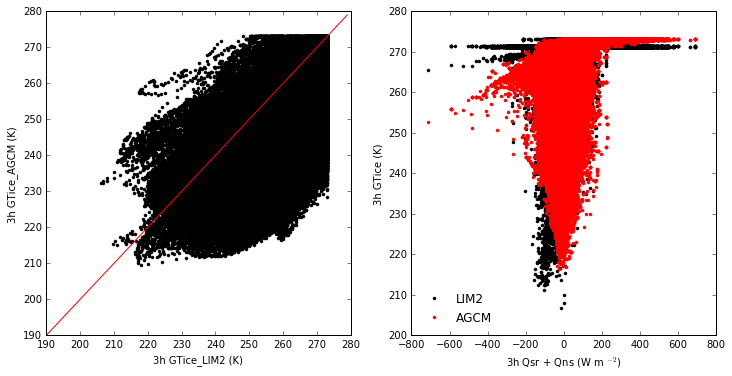

In [101]:
save_pdf = True

fig, (axtl, axtr)  = plt.subplots(1,2, figsize=(12,12))
fig.subplots_adjust(top=0.5)
axtl.plot(o_tepice_all.flatten(),gtice_ocn_all.flatten(), 'k.', rasterized=True)
axtl.plot(np.arange(180,280), np.arange(180,280), 'r')
axtl.axis([190, 280, 190, 280])
axtl.set_ylabel('3h GTice_AGCM (K)')
axtl.set_xlabel('3h GTice_LIM2 (K)')
#axtr.hist2d(o_tepice.flatten(),gtice_ocn.flatten())
axtr.plot((O_QnsIce_all + O_QsrIce_all).flatten(), o_tepice_all.flatten(), 'k.', label='LIM2', rasterized=True)
axtr.plot((O_QnsIce_all + O_QsrIce_all).flatten(), gtice_ocn_all.flatten(), 'r.', label='AGCM', rasterized=True)
axtr.set_ylabel('3h GTice (K)')
axtr.set_xlabel('3h Qsr + Qns (W m $^{-2}$)')
axtr.legend(scatterpoints=1, numpoints=1, frameon=False, loc='best')

if save_pdf:
    fig.savefig(outpref + '_GTICE_scatter_3h.pdf', bbox_inches='tight')

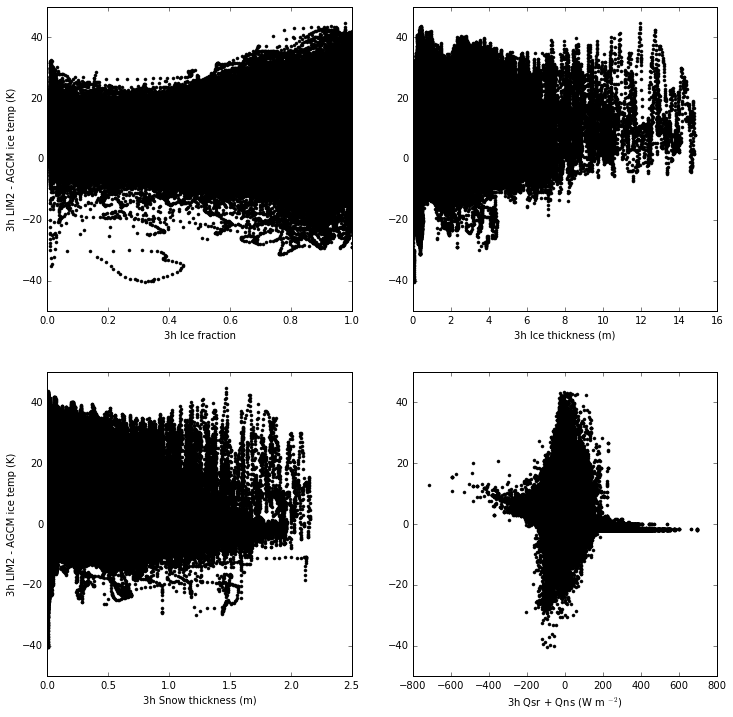

In [102]:
save_pdf = True

fig, ((axtl, axtr), (axl, axr))  = plt.subplots(2,2, figsize=(12,12))

axl.plot(osnwtck_all.flatten()/330.0, ice_temp_diff_all.flatten(), 'k.', rasterized=True)
axr.plot(O_QnsIce_all.flatten() + O_QsrIce_all.flatten(), ice_temp_diff_all.flatten(), 'k.', rasterized=True)

axtl.plot(oicefrc_all.flatten(), ice_temp_diff_all.flatten(), 'k.', rasterized=True)
axtr.plot(oicetck_all.flatten()/900., ice_temp_diff_all.flatten(), 'k.', rasterized=True)
axl.set_ylabel('3h LIM2 - AGCM ice temp (K)')
axtl.set_ylabel('3h LIM2 - AGCM ice temp (K)')
axr.set_xlabel('3h Qsr + Qns (W m $^{-2}$)')


axl.set_xlabel('3h Snow thickness (m)')
#fig.delaxes(axr)
axtl.set_xlabel('3h Ice fraction')
axtr.set_xlabel('3h Ice thickness (m)')
if save_pdf:
    fig.savefig(outpref + 'LIM2-AGCM_GTICE_scatter_3h.pdf', bbox_inches='tight')
    
save_pdf=False    

In [ ]:
iicethic_all = np.ma.masked_equal(cd.loadvar(ifile_icemod, 'iicethic'), 0)


In [ ]:

fig, ((axl))  = plt.subplots(1,1, figsize=(12,12))
axl.hist(np.ma.masked_equal(ice_temp_diff_all,0).flatten().compressed(), normed=True)
axl.set_title('asd')

In [ ]:
fig, ((axr))  = plt.subplots(1,1, figsize=(8,8))
from matplotlib.colors import LogNorm

(H, xedges, yedges, img) = axr.hist2d(o_tepice_all.flatten(),gtice_ocn_all.flatten(), bins=100, norm=LogNorm(),
                                    cmap='viridis', cmin=0, cmax=1e5)
#add_cbar(img, axl, 'K')
axr.plot(np.arange(180,278), np.arange(180,278), 'k')
axr.plot(np.arange(180,278), np.arange(190,288), 'k--')
axr.plot(np.arange(190,288), np.arange(180,278), 'k--')

axr.axis([190, 275, 190, 275])
axr.set_title('')
axr.set_ylabel('3h GTice_AGCM (K)')
axr.set_xlabel('3h GTice_LIM2 (K)')

In [ ]:
from scipy import stats

stats.mode(np.ma.masked_equal(ice_temp_diff_all,0).flatten().compressed())

## Convert output to pdf without any code blocks!

In [ ]:
if save_nb:
    import os 
    os.system(("ipython nbconvert --to=latex --template=latex_nocode.tplx " +
               "--to=PDF NEMO_coupling_diagnostics.ipynb"))
    os.system("mv NEMO_coupling_diagnostics.pdf " + outpref + "merged_diag.pdf")                     